In [5]:
pip install nashpy

In [44]:
import nashpy as nash
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from numpy.linalg import eig

# Parameters
c = 1 # cost of attack
d = 2 # cost of defence
w = 5 # Loss to the defender
v = 1 # probability of successful defence
a = 10 # benefit of attack
b = 10 # benefit of defence
m = 0 # probability of catching attacker for unsuccessful attack
n = 0 # probability of catching attacker for successful attack
p = 0 # Fine to attacker for a successful attack
s = 0 # Fine to attacker for an unsuccessful attack
#r = 2 Ratio of attack benefit to the defender's loss

# Payoff matrices based on the given parameters
payoff_defender = np.array([
        [ 0, -w],
        [-d+b, -d + v*b - w*(1 - v)],
    ])
payoff_attacker = np.array([
        [ 0, 0],
        [-c+a - m* p, -c+a*(1-v) - v * n * s - (1-v) *m * p],
    ])

prisoners_dilemma = nash.Game(payoff_defender, payoff_attacker)
prisoners_dilemma

Bi matrix game with payoff matrices:

Row player:
[[ 0 -5]
 [ 8  8]]

Column player:
[[ 0  0]
 [ 9 -1]]

In [45]:
# Define the replicator dynamics equations
def F_beta(beta, alpha):
    return beta * (1 - beta) * (b - d - b*alpha + v*b*alpha + v*w*alpha)

def F_alpha(alpha, beta):
    return alpha * (1 - alpha) * (-c + a - m*p - a*v*beta - v*n*s*beta + v*m*p*beta)

# Jacobian matrix to determine stability
def jacobian(beta, alpha):
    # Partial derivative of F_beta with respect to alpha
    dF_beta_dalpha = beta * (1 - beta) * (-b + v*b + v*w)

    # Partial derivative of F_alpha with respect to beta
    dF_alpha_dbeta = alpha * (1 - alpha) * (-a*v - v*n*s + v*m*p)

    # Partial derivative of F_beta with respect to beta
    dF_beta_dbeta = (2 * beta - 1) * (d - b + b*alpha - v*b*alpha - v*w*alpha)
                    #+ \(1 - 2 * beta) * beta * (1 - beta)

    # Partial derivative of F_alpha with respect to alpha
    dF_alpha_dalpha = (2 * alpha - 1) * (c - a + m*p + a*v*beta + v*n*s*beta - v*m*p*beta)
                      #+ \(1 - 2 * alpha) * alpha * (1 - alpha)

    # Return the 2x2 Jacobian matrix
    #return np.array([[dF_alpha_dalpha, dF_alpha_dbeta],
      #               [dF_beta_dalpha, dF_beta_dbeta]])

    return np.array([[dF_beta_dbeta, dF_beta_dalpha],
                     [dF_alpha_dbeta, dF_alpha_dalpha]])

# Example values for alpha and beta
alpha = 0
beta = 0

# Call the jacobian function and print the result
J = jacobian(beta, alpha)
print("Jacobian matrix:")
print(J)


Jacobian matrix:
[[8 0]
 [0 9]]


In [46]:
# Function to find equilibrium points by solving the system F_alpha = 0, F_beta = 0
def equilibrium_points(guess):
    def equations(p):
        alpha, beta = p
        return (F_beta(beta, alpha), F_alpha(alpha, beta))
    return fsolve(equations, guess)

# Get equilibrium points with a rough guess
equilibria = equilibrium_points([1, 1])

alpha_eq, beta_eq = equilibria
print(f"Equilibrium point: beta = {beta_eq}, alpha = {alpha_eq}")

# Compute the Jacobian matrix at the equilibrium point
J = jacobian(beta_eq, alpha_eq)
print(f"Jacobian matrix at equilibrium:\n{J}")

Equilibrium point: beta = 1.0, alpha = 1.0
Jacobian matrix at equilibrium:
[[-13.   0.]
 [ -0.   1.]]


Eigenvalues: [-13.   1.]
Stability: Saddle


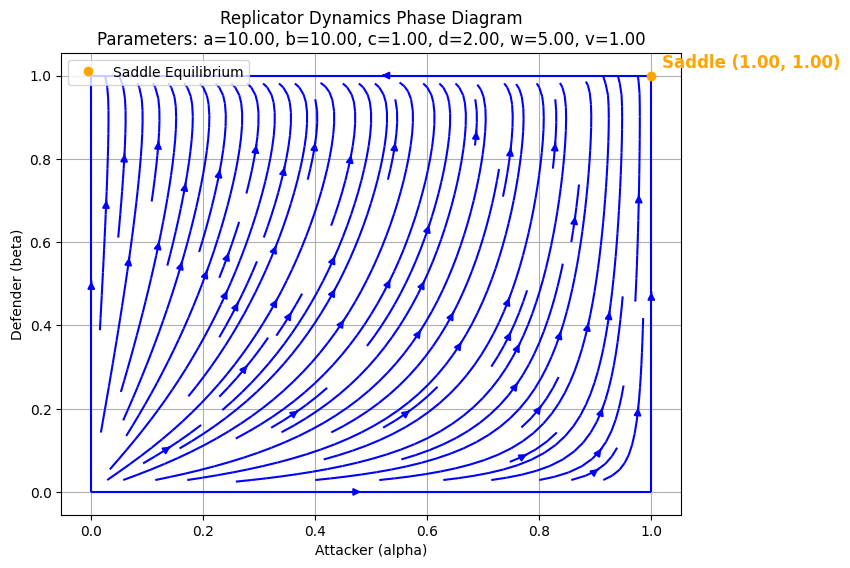

In [47]:
# Calculate eigenvalues to determine stability
eigenvalues = eig(J)[0]
print(f"Eigenvalues: {eigenvalues}")

# Stability classification based on eigenvalues
if np.all(np.real(eigenvalues) < 0):
    stability = "Stable"
    color = 'green'
elif np.all(np.real(eigenvalues) > 0):
    stability = "Unstable"
    color = 'red'
else:
    stability = "Saddle"
    color = 'orange'

print(f"Stability: {stability}")

# Plot the phase diagram and equilibrium points
alpha_vals = np.linspace(0, 1, 100)
beta_vals = np.linspace(0, 1, 100)
alpha_grid, beta_grid = np.meshgrid(alpha_vals, beta_vals)

F_alpha_vals = F_alpha(alpha_grid, beta_grid)
F_beta_vals = F_beta(beta_grid, alpha_grid)

plt.figure(figsize=(8, 6))
plt.streamplot(alpha_vals, beta_vals, F_alpha_vals, F_beta_vals, color='blue', density=1.2)

# Plot the equilibrium point
plt.plot(alpha_eq, beta_eq, 'o', color=color, label=f'{stability} Equilibrium')

# Label the equilibrium point on the graph
plt.text(alpha_eq + 0.02, beta_eq + 0.02, f'{stability} ({alpha_eq:.2f}, {beta_eq:.2f})',
         color=color, fontsize=12, weight='bold')

# Labels and legend
plt.xlabel('Attacker (alpha)')
plt.ylabel('Defender (beta)')
plt.title(f'Replicator Dynamics Phase Diagram\nParameters: a={a:.2f}, b={b:.2f}, c={c:.2f}, d={d:.2f}, w={w:.2f}, v={v:.2f}')

# Adding a legend to distinguish stable, unstable, and saddle points
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


<ipython-input-8-3d61a07518f8>:6: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  return fsolve(equations, guess)


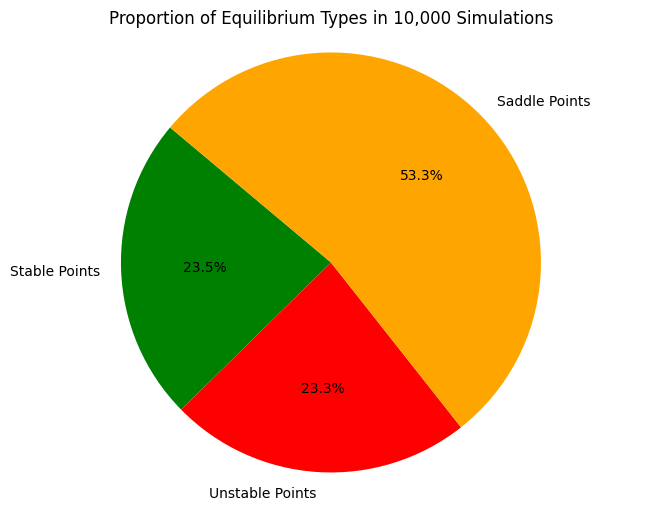

In [23]:
# Initialize counters for different types of equilibria
stable_count, unstable_count, saddle_count = 0, 0, 0

# Set up the simulation for 1000 iterations
for _ in range(10000):
    # Generate random values for parameters a, b, c, d, w
    a = np.random.uniform(0.1, 1)
    b = np.random.uniform(0.1, 1)
    c = np.random.uniform(0.1, 1)
    d = np.random.uniform(0.1, 1)
    w = np.random.uniform(0.1, 1)

    # Redefine equilibrium points based on new parameters
    equilibria = equilibrium_points([0.5, 0.5])
    alpha_eq, beta_eq = equilibria

    # Compute the Jacobian matrix at the new equilibrium point
    J = jacobian(beta_eq, alpha_eq)

    # Calculate eigenvalues to determine stability
    eigenvalues = eig(J)[0]

    # Classify the stability based on eigenvalues
    if np.all(np.real(eigenvalues) < 0):
        stable_count += 1
    elif np.all(np.real(eigenvalues) > 0):
        unstable_count += 1
    else:
        saddle_count += 1

# Create a pie chart of the results
labels = ['Stable Points', 'Unstable Points', 'Saddle Points']
sizes = [stable_count, unstable_count, saddle_count]
colors = ['green', 'red', 'orange']

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of Equilibrium Types in 10,000 Simulations')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()
